thetas=array([0.   , 0.001, 0.002, ..., 0.998, 0.999, 1.   ])
prior=array([0.000999, 0.000999, 0.000999, ..., 0.000999, 0.000999, 0.000999])
posterior=array([0.00000000e+00, 1.99800200e-06, 3.99600400e-06, ...,
       1.99400599e-03, 1.99600400e-03, 1.99800200e-03])


Text(0, 0.5, '$p(\\theta)$')

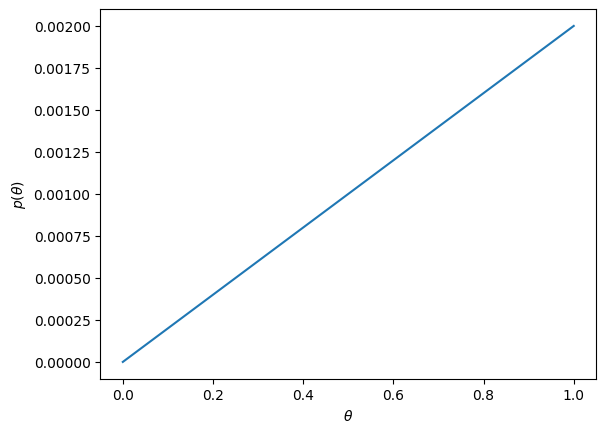

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

# 本来は連続値だが扱いづらいので、細かく刻んだ離散値を使ってベルヌーイ分布のパラメータ候補を定義
thetas = np.linspace(0, 1, 1001)
print(f"{thetas=}")

likelihood_func = lambda r: thetas if r else 1 - thetas


def calc_posterior(r: int, prior: np.ndarray) -> np.ndarray:
    lp = likelihood_func(r) * prior  # 尤度関数と事前分布の積
    return lp / lp.sum()  # 確率分布の定義を満たすために、Σθp(r|θ)p(θ)で割って正規化


# 事前分布(i.e. 最初に我々が持つ信念) p(theta) を一様分布として初期化(まだ何も前提知識がないので)
prior = np.array([1.0 / len(thetas) for _ in thetas])
print(f"{prior=}")

# 1回の試行後(クリックが観測された場合)の事後分布を計算して、事前分布を更新
posterior = calc_posterior(1, prior)
print(f"{posterior=}")

plt.plot(thetas, posterior)
plt.xlabel(r"$\theta$")
plt.ylabel(r"$p(\theta)$")


Text(0.5, 1.0, '$p(\\theta|Data)$ after 40 trials')

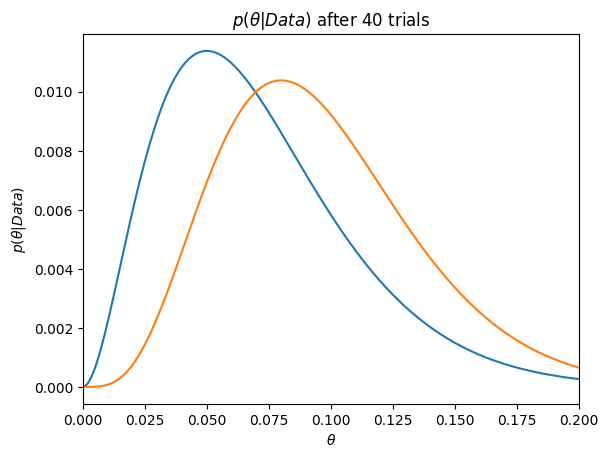

In [2]:
# 40回の試行後の事後分布を計算
rewards_A = [1] * 2 + [0] * 38
rewards_B = [1] * 4 + [0] * 46

# 信念 \hat{p}(theta) の初期値(事前分布)を、一様分布として初期化
p_theta_A = np.array([1.0 / len(thetas) for _ in thetas])
p_theta_B = np.array([1.0 / len(thetas) for _ in thetas])

for r_A in rewards_A:
    # 観測結果に基づいて得られる事後分布によって、信念 \hat{p}(theta) を更新していく
    p_theta_A = calc_posterior(r_A, p_theta_A)

for r_B in rewards_B:
    p_theta_B = calc_posterior(r_B, p_theta_B)


plt.plot(thetas, p_theta_A)
plt.plot(thetas, p_theta_B)
plt.xlabel(r"$\theta$")
plt.ylabel(r"$p(\theta|Data)$")
plt.xlim(0.0, 0.2)
plt.title(r"$p(\theta|Data)$ after 40 trials")

Text(0.5, 1.0, '$p(\\theta|Data)$ after 40 trials')

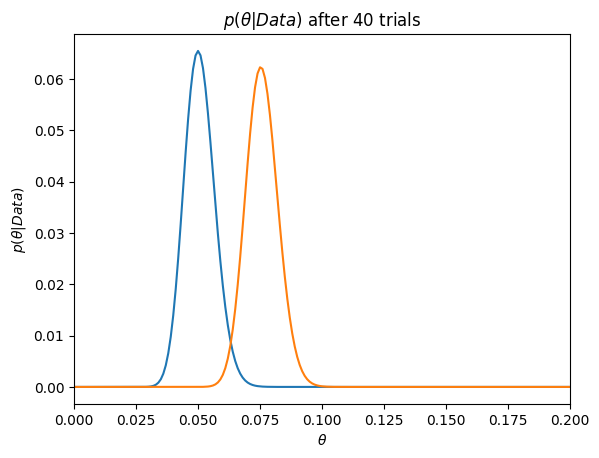

In [3]:
# 1500回くらいの試行後の事後分布を計算
rewards_A = [1] * 64 + [0] * 1216
rewards_B = [1] * 128 + [0] * 1572

# p(theta)の初期値(事前分布)を、一様分布として初期化
p_theta_A = np.array([1.0 / len(thetas) for _ in thetas])
p_theta_B = np.array([1.0 / len(thetas) for _ in thetas])

for r_A in rewards_A:
    p_theta_A = calc_posterior(r_A, p_theta_A)

for r_B in rewards_B:
    p_theta_B = calc_posterior(r_B, p_theta_B)


plt.plot(thetas, p_theta_A)
plt.plot(thetas, p_theta_B)
plt.xlabel(r"$\theta$")
plt.ylabel(r"$p(\theta|Data)$")
plt.xlim(0.0, 0.2)
plt.title(r"$p(\theta|Data)$ after 40 trials")

Text(0.5, 1.0, '$p(\\theta|Data)$ after 40 trials, alternative solution')

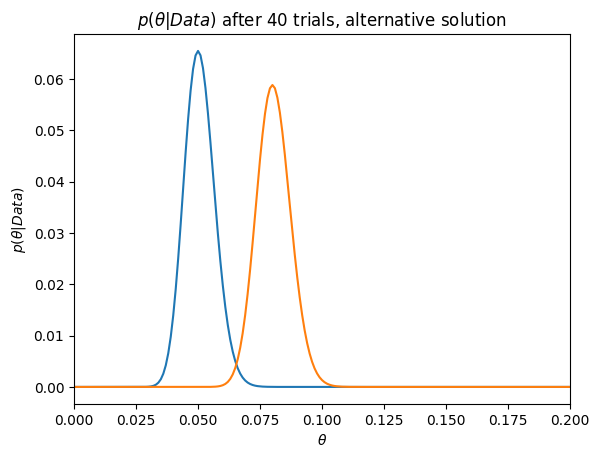

In [ ]:
# 別解1: 試行の繰り返しをまとめる
# 試行回数分だけ事後分布を計算するのではなく、試行回数によらず1回の計算で事後分布を求めるver.

# 二項分布に基づく尤度関数 (ここで尤度関数は確率分布である必要はないので、nCaという係数は省略してる)
likelihood_func = lambda a, N: thetas**a * (1 - thetas) ** (N - a)
# ちなみに、nCaを省略しない場合は以下。どのみち最終的には正規化してスケールを合わせるので、同じ
# likelihood_func = lambda a, N: math.comb(N, a) * thetas**a * (1 - thetas) ** (N - a)


def calc_posterior(a: int, N: int, prior: np.ndarray) -> np.ndarray:
    lp = likelihood_func(a, N) * prior  # 尤度関数と事前分布の積
    return lp / lp.sum()  # 総和を1.0にして確率分布の定義を満たすために、正規化


# 信念(brief)の初期値として、一様分布を仮定
p_theta_A = np.array([1.0 / len(thetas) for _ in thetas])
p_theta_B = np.array([1.0 / len(thetas) for _ in thetas])

# 観測データに基づく事後分布を計算して、信念を更新
p_theta_A = calc_posterior(64, 1280, p_theta_A)
p_theta_B = calc_posterior(128, 1600, p_theta_B)

plt.plot(thetas, p_theta_A)
plt.plot(thetas, p_theta_B)
plt.xlabel(r"$\theta$")
plt.ylabel(r"$p(\theta|Data)$")
plt.xlim(0.0, 0.2)
plt.title(r"$p(\theta|Data)$ after 40 trials, alternative solution")

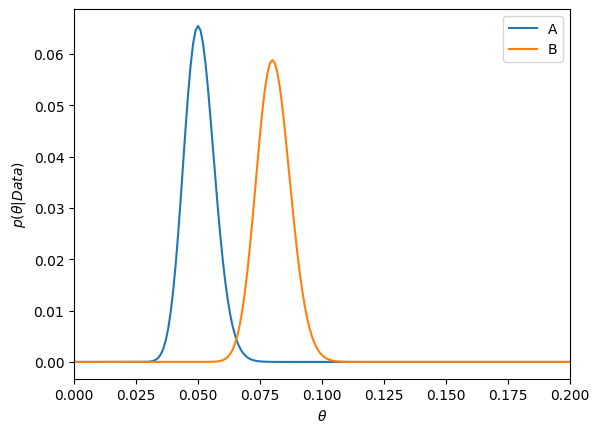

In [10]:
# 別解2: ベータ分布を使う
# 報酬データrが与えられるたびに更新される 尤度関数✖️事前分布 の値を一般化するver.

# 具体的には...
# 今回の例では事前分布が一様分布だったので、ベルヌーイ分布の尤度関数 θ^{r}(1-θ)^{(1-r)} をどんどん掛け合わせていく操作
# つまり新たなデータ r が得られる度に、θ及び1-θの積が積み上がっていく！
# -> 一般化すると「N回の試行でr=1がc回観測された時の尤度関数✖️事前分布」の値はθ^{c}(1-θ)^{(N-c)} になる
# それを確率分布の定義を満たすために、Σθ^{c}(1-θ)^{(N-c)}で割って正規化すると...
# -> p(θ|c, N) = θ^{c}(1-θ)^{(N-c)} / Σθ^{c}(1-θ)^{(N-c)} (これはベータ分布の形!)

# ベータ分布の定義: p(θ|a, b) = θ^{a-1}(1-θ)^{b-1} / \int_{0}^{1} θ^{a-1}(1-θ)^{b-1} dθ
# 特にa=b=1の時は一様分布になる

# 今回の例では、ある尤度関数に対して、事後分布も事前分布も同じ種類の確率分布で表すことができる
# (事後分布はa=c+1, b=N-c+1のベータ分布、事前分布はa=b=1のベータ分布)
# ->これを共役事前分布(conjugate prior)と呼ぶ


def beta_dist_func(alpha: int, beta: int) -> np.ndarray:
    numerator = thetas ** (alpha - 1) * (1 - thetas) ** (beta - 1)
    return numerator / numerator.sum()


def calc_posterior(c: int, N: int) -> np.ndarray:
    """ここでcは報酬が1であった回数、Nは試行回数。
    この別解だと、事前分布を受け取らずに事後分布を計算する関数になっている。
    これは共役事前分布の性質によって、事後分布も事前分布も一般化されたベータ分布で表せるため。
    """
    return beta_dist_func(c + 1, N - c + 1)


p_theta_A = calc_posterior(64, 1280)
p_theta_B = calc_posterior(128, 1600)
plt.plot(thetas, p_theta_A, label="A")
plt.plot(thetas, p_theta_B, label="B")
plt.xlabel(r"$\theta$")
plt.ylabel(r"$p(\theta|Data)$")
plt.xlim(0.0, 0.2)
plt.legend()

hmv_thethas=array([0.04 , 0.041, 0.042, 0.043, 0.044, 0.045, 0.046, 0.047, 0.048,
       0.049, 0.05 , 0.051, 0.052, 0.053, 0.054, 0.055, 0.056, 0.057,
       0.058, 0.059, 0.06 , 0.061, 0.062])
is_included_HDI_list=array([False, False, False, ..., False, False, False])


Text(0.05100000000000001, 0, '95% HDI')

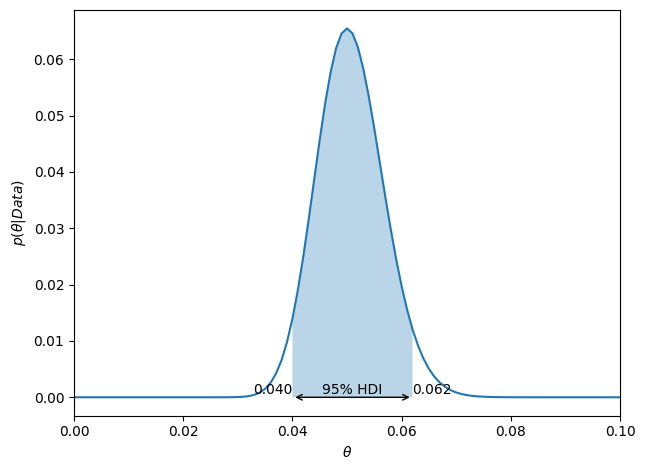

In [24]:
# 事後分布から決断を下す。
# HDIを使った仮設検定


def calc_highest_mass_values(
    xs: np.ndarray,
    ps: np.ndarray,
    alpha: float = 0.95,
) -> np.ndarray:
    """確率質量ランキング上位(highest mass values)の値を返す。
    Args:
        xs: 離散化された確率変数の配列
        ys: 各確率変数の値に対応する確率質量
        alpha: 区間の幅 (デフォルトは95%)
    """
    sorted_values = sorted(zip(xs, ps), key=lambda x: x[1], reverse=True)
    sorted_values_array = np.array(sorted_values)
    xs = sorted_values_array[:, 0]
    ps = sorted_values_array[:, 1]
    return np.sort(xs[np.cumsum(ps) <= alpha])


hmv_thethas = calc_highest_mass_values(thetas, p_theta_A)
print(f"{hmv_thethas=}")
is_included_HDI_list = (hmv_thethas.min() <= thetas) & (thetas <= hmv_thethas.max())
print(f"{is_included_HDI_list=}")

plt.plot(thetas, p_theta_A, label="A")

# HDIをプロット
plt.fill_between(
    thetas[is_included_HDI_list],
    p_theta_A[is_included_HDI_list],
    0,
    alpha=0.3,
)
plt.xlabel(r"$\theta$")
plt.ylabel(r"$p(\theta|Data)$")
plt.tight_layout()
plt.xlim(0.0, 0.1)

# 注釈をつける
plt.annotate(
    "",
    xy=(hmv_thethas.min(), 0),  # 矢印の始点
    xytext=(hmv_thethas.max(), 0),  # 矢印の終点
    # 矢印のスタイル
    arrowprops=dict(color="black", arrowstyle="<->"),
)
plt.annotate(
    "%.3f" % hmv_thethas.min(),
    xy=(hmv_thethas.min(), 0),
    ha="right",
    va="bottom",
)
plt.annotate(
    "%.3f" % hmv_thethas.max(),
    xy=(hmv_thethas.max(), 0),
    ha="left",
    va="bottom",
)
plt.annotate(
    "95% HDI",
    xy=(hmv_thethas.mean(), 0),
    ha="center",
    va="bottom",
)

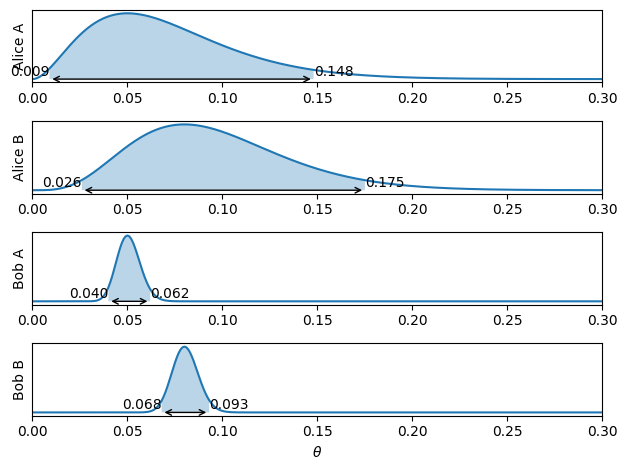

In [27]:
def plot_hdi(ps: np.ndarray, thetas: np.ndarray, label: str):
    hmv_thethas = calc_highest_mass_values(thetas, ps)
    is_included_HDI_list = (hmv_thethas.min() <= thetas) & (thetas <= hmv_thethas.max())
    plt.plot(thetas, ps)
    plt.fill_between(
        thetas[is_included_HDI_list],
        ps[is_included_HDI_list],
        0,
        alpha=0.3,
    )
    plt.annotate(
        "",
        xy=(hmv_thethas.min(), 0),  # 矢印の始点
        xytext=(hmv_thethas.max(), 0),  # 矢印の終点
        # 矢印のスタイル
        arrowprops=dict(color="black", arrowstyle="<->"),
    )
    plt.annotate(
        "%.3f" % hmv_thethas.min(),
        xy=(hmv_thethas.min(), 0),
        ha="right",
        va="bottom",
    )
    plt.annotate(
        "%.3f" % hmv_thethas.max(),
        xy=(hmv_thethas.max(), 0),
        ha="left",
        va="bottom",
    )
    plt.xlim(0.0, 0.3)
    plt.ylabel(label)
    plt.yticks([])


plt.subplot(4, 1, 1)
alice_a = calc_posterior(2, 40)
plot_hdi(alice_a, thetas, "Alice A")

plt.subplot(4, 1, 2)
alice_b = calc_posterior(4, 50)
plot_hdi(alice_b, thetas, "Alice B")

plt.subplot(4, 1, 3)
bob_a = calc_posterior(64, 1280)
plot_hdi(bob_a, thetas, "Bob A")

plt.subplot(4, 1, 4)
bob_b = calc_posterior(128, 1600)
plot_hdi(bob_b, thetas, "Bob B")

plt.xlabel(r"$\theta$")
plt.tight_layout()
plt.show()

- 全体の傾向: 
  - ボブのデザイン案はアリスのデザイン案に比べてクリック率のHDIが狭い。
    - -> ボブのデザイン案のクリック率は、より特定の値の周辺に確認を持って推論される。
- この結果を利用して、さまざまな仮説を検証してみる。
  - ケース1
    - 仮説: デザインB案のクリック率は5%よりも大きい。
    - 定量的評価: 
      - デザインB案のクリック率の95%HDIの最小値は5%よりも大きい。
    - 結果:
      - アリスのレポートのデザインB案のHDIは[0.026, 0.175]、ボブのレポートのデザインB案のHDIは[0.068, 0.093]。
        - -> よってアリスのレポートではデザインB案のクリック率は5%よりも大きいと結論づけられないが、ボブのレポートでは5%よりも大きいと結論づけられる。
      - 一方で、この議論ではHDIの最小値が0.0501だったとしても、デザインB案のクリック率が5%よりも大きいと結論づけられる。
        - ウェブサイトやアプリケーションによっては、この程度の違いは誤差だと考えたい場合もあるかも。
        - -> 従って、**5%前後0.5%つまり[4.5%, 5.5%]は5%と実質同じと考え、この区間とHDIを比較する方法**も考えられる。
          - このように、特定の数値の周囲に定義した「実質同じ」区間は、**ROPE**(Region of Practical Equivalence)と呼ばれる。
        - つまり、**ROPEとHDIを比較する意思決定ルール**!
      - HDIとROPEをを使った意思決定ルール(Kruschke, 2014の方法を参考)
        - 対象値のROPE全体がHDIの外にあるとき、その対象値を棄却する、つまり異なると結論づける。
        - 対象値のROPEの中にHDI全体が含まれるとき、その値を採用する。つまり等しいと結論づける。
        - その他の場合は、結論づけることを控える。
  - ケース2
    - 仮説: デザインB案のクリック率はデザインA案のクリック率よりも大きい。
    - 定量的評価:
      - デザインB案のクリック率の95%HDI全体がデザインA案のクリック率の95%HDIの外にあるとき、2つのクリック率は異なる。
        - 特に前者の最小値が後者の最小値より大きい時、デザインB案のクリック率はA案よりも大きい。
        - 特に前者の最大値が後者の最大値より小さい時、デザインB案のクリック率はA案よりも小さい。
      - その他の場合は、結論づけることを控える。
    - 結果:
      - アリスのレポートでは、デザインA案のHDIは[0.009, 0.148]、デザインB案のHDIは[0.026, 0.175]だった。よって、両者の間のクリック率の大小は結論づけられない。
      - 一方で、ボブのレポートでは、デザインA案のHDIは[0.040, 0.062]、デザインB案のHDIは[0.068, 0.093]だった。よって、デザインB案のクリック率はデザインA案のクリック率よりも大きいと結論づけられる。

# 別解: 新たな確率変数を導入する

In [ ]:
# 新たな確率変数を導入する